**Copyright 2020 DeepMind Technologies Limited.**


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title Imports
import functools
import os
import requests
from subprocess import getstatusoutput
from matplotlib import pyplot as plt
from matplotlib import animation as plt_animation
from matplotlib import rc
import numpy as np
from pathlib import Path
import tensorflow as tf

rc('animation', html='jshtml')
import jax
jax.config.update("jax_enable_x64", True)

from dm_hamiltonian_dynamics_suite import load_datasets
from dm_hamiltonian_dynamics_suite import datasets

2024-08-03 21:23:09.052833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 21:23:09.889713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# specify the dataset that you want to download
dataset_name = "toy_physics/mass_spring_colors_friction" #@param  ["toy_physics/mass_spring", "toy_physics/mass_spring_colors", "toy_physics/mass_spring_colors_friction", "toy_physics/mass_spring_long_trajectory", "toy_physics/mass_spring_colors_long_trajectory", "toy_physics/pendulum", "toy_physics/pendulum_colors", "toy_physics/pendulum_colors_friction", "toy_physics/pendulum_long_trajectory", "toy_physics/pendulum_colors_long_trajectory", "toy_physics/double_pendulum", "toy_physics/double_pendulum_colors", "toy_physics/double_pendulum_colors_friction", "toy_physics/two_body", "toy_physics/two_body_colors", "molecular_dynamics/lj_4", "molecular_dynamics/lj_16", "multi_agent/matching_pennies", "multi_agent/matching_pennies_long_trajectory", "multi_agent/rock_paper_scissors", "multi_agent/rock_paper_scissors_long_trajectory", "mujoco_room/circle", "mujoco_room/spiral"]

In [3]:
#@title Helper functions
DATASETS_URL = "gs://dm-hamiltonian-dynamics-suite"
DATASETS_FOLDER = (Path("../../") / "data" / "tensorflow_datasets").resolve()
print("Datasets_folder", DATASETS_FOLDER)
DATASETS_FOLDER.mkdir(exist_ok=True)

def download_file(file_url, destination_file):
  print("Downloading", file_url, "to", destination_file)
  command = f"gsutil cp {file_url} {destination_file}"
  status_code, output = getstatusoutput(command)
  if status_code != 0:
    raise ValueError(output)

def download_dataset(dataset_name: str):
  """Downloads the provided dataset from the DM Hamiltonian Dataset Suite"""
  destination_folder = os.path.join(DATASETS_FOLDER, dataset_name)
  dataset_url = os.path.join(DATASETS_URL, dataset_name)
  os.makedirs(destination_folder, exist_ok=True)
  if "long_trajectory" in dataset_name:
    files = ("features.txt", "test.tfrecord")
  else:
    files = ("features.txt", "train.tfrecord", "test.tfrecord")
  for file_name in files:
    file_url = os.path.join(dataset_url, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    if os.path.exists(destination_file):
      print("File", file_url, "already present.")
      continue
    download_file(file_url, destination_file)


def unstack(value: np.ndarray, axis: int = 0):
  """Unstacks an array along an axis into a list"""
  split = np.split(value, value.shape[axis], axis=axis)
  return [np.squeeze(v, axis=axis) for v in split]


def make_batch_grid(
    batch: np.ndarray, 
    grid_height: int,
    grid_width: int, 
    with_padding: bool = True
):
  """Makes a single grid image from a batch of multiple images."""
  assert batch.ndim == 5
  assert grid_height * grid_width >= batch.shape[0]
  batch = batch[:grid_height * grid_width]
  batch = batch.reshape((grid_height, grid_width) + batch.shape[1:])
  if with_padding:
    batch = np.pad(batch, pad_width=[[0, 0], [0, 0], [0, 0],
                                      [1, 0], [1, 0], [0, 0]],
                    mode="constant", constant_values=1.0)
  batch = np.concatenate(unstack(batch), axis=-3)
  batch = np.concatenate(unstack(batch), axis=-2)
  if with_padding:
    batch = batch[:, 1:, 1:]
  return batch


def plot_animation_from_batch(
    batch: np.ndarray, 
    grid_height, 
    grid_width, 
    with_padding=True, 
    figsize=None
):
  """Plots an animation of the batch of sequences."""
  if figsize is None:
    figsize = (grid_width, grid_height)
  batch = make_batch_grid(batch, grid_height, grid_width, with_padding)
  batch = batch[:, ::-1]
  fig = plt.figure(figsize=figsize)
  plt.close()
  ax = fig.add_subplot(1, 1, 1)
  ax.axis('off')
  img = ax.imshow(batch[0])  
  def frame_update(i):
    i = int(np.floor(i).astype("int64"))
    img.set_data(batch[i])
    return [img]
  anim = plt_animation.FuncAnimation(
      fig=fig, 
      func=frame_update,
      frames=np.linspace(0.0, len(batch), len(batch) * 5 + 1)[:-1],
      save_count=len(batch),
      interval=10, 
      blit=True
  )
  return anim


def plot_sequence_from_batch(
    batch: np.ndarray,
    t_start: int = 0,
    with_padding: bool = True, 
    fontsize: int = 20):
  """Plots all of the sequences in the batch."""
  n, t, dx, dy = batch.shape[:-1]
  xticks = np.linspace(dx // 2, t * (dx + 1) - 1 - dx // 2, t)
  xtick_labels = np.arange(t) + t_start
  yticks = np.linspace(dy // 2, n * (dy + 1) - 1 - dy // 2, n)
  ytick_labels = np.arange(n)
  batch = batch.reshape((n * t, 1) + batch.shape[2:])
  batch = make_batch_grid(batch, n, t, with_padding)[0]
  plt.imshow(batch.squeeze())
  plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=fontsize)
  plt.yticks(ticks=yticks, labels=ytick_labels, fontsize=fontsize)


def visualize_dataset(
    dataset_path: str,
    sequence_lengths: int = 60,
    grid_height: int = 2, 
    grid_width: int = 5):
  """Visualizes a dataset loaded from the path provided."""
  batch_size = grid_height * grid_width
  ds = load_datasets.load_dataset(
      path=dataset_path,
      tfrecord_prefix="test",
      sub_sample_length=sequence_lengths,
      per_device_batch_size=batch_size,
      num_epochs=None,
      drop_remainder=True,
      shuffle=False,
      shuffle_buffer=100
  )
  
  print("Loaded dataset:\n", ds)
  
  sample = next(iter(ds))
  batch_x = sample['x'].numpy()
  batch_image = sample['image'].numpy()
  # Plot real system dimensions
  plt.figure(figsize=(24, 8))
  for i in range(batch_x.shape[-1]):
    plt.subplot(1, batch_x.shape[-1], i + 1)
    plt.title(f"Samples from dimension {i+1}")
    plt.plot(batch_x[:, :, i].T)
  plt.show()
  # Plot a sequence of 50 images
  plt.figure(figsize=(30, 10))
  plt.title("Samples from 50 steps sub sequences.")
  plot_sequence_from_batch(batch_image[:, :50])
  plt.show()
  # Plot animation
  return plot_animation_from_batch(batch_image, grid_height, grid_width)

Datasets_folder /home/mstoelzle/phd/uncovering-archetype-networks/data/tensorflow_datasets


In [4]:
#@title Download the dataset
download_dataset(dataset_name)

File gs://dm-hamiltonian-dynamics-suite/toy_physics/mass_spring_colors_friction/features.txt already present.
File gs://dm-hamiltonian-dynamics-suite/toy_physics/mass_spring_colors_friction/train.tfrecord already present.
File gs://dm-hamiltonian-dynamics-suite/toy_physics/mass_spring_colors_friction/test.tfrecord already present.


2024-08-03 21:23:23.248238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-03 21:23:23.248911: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loaded dataset:
 <_PrefetchDataset element_spec={'dx_dt': TensorSpec(shape=(10, 60, 2), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(10, 60, 32, 32, 3), dtype=tf.float32, name=None), 'other': {'color_index': TensorSpec(shape=(10, 1, 1), dtype=tf.int32, name=None), 'k': TensorSpec(shape=(10, 1), dtype=tf.float32, name=None), 'm': TensorSpec(shape=(10, 1), dtype=tf.float32, name=None), 'offset': TensorSpec(shape=(10, 1, 2), dtype=tf.float32, name=None)}, 'x': TensorSpec(shape=(10, 60, 2), dtype=tf.float32, name=None)}>


2024-08-03 21:23:24.283753: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


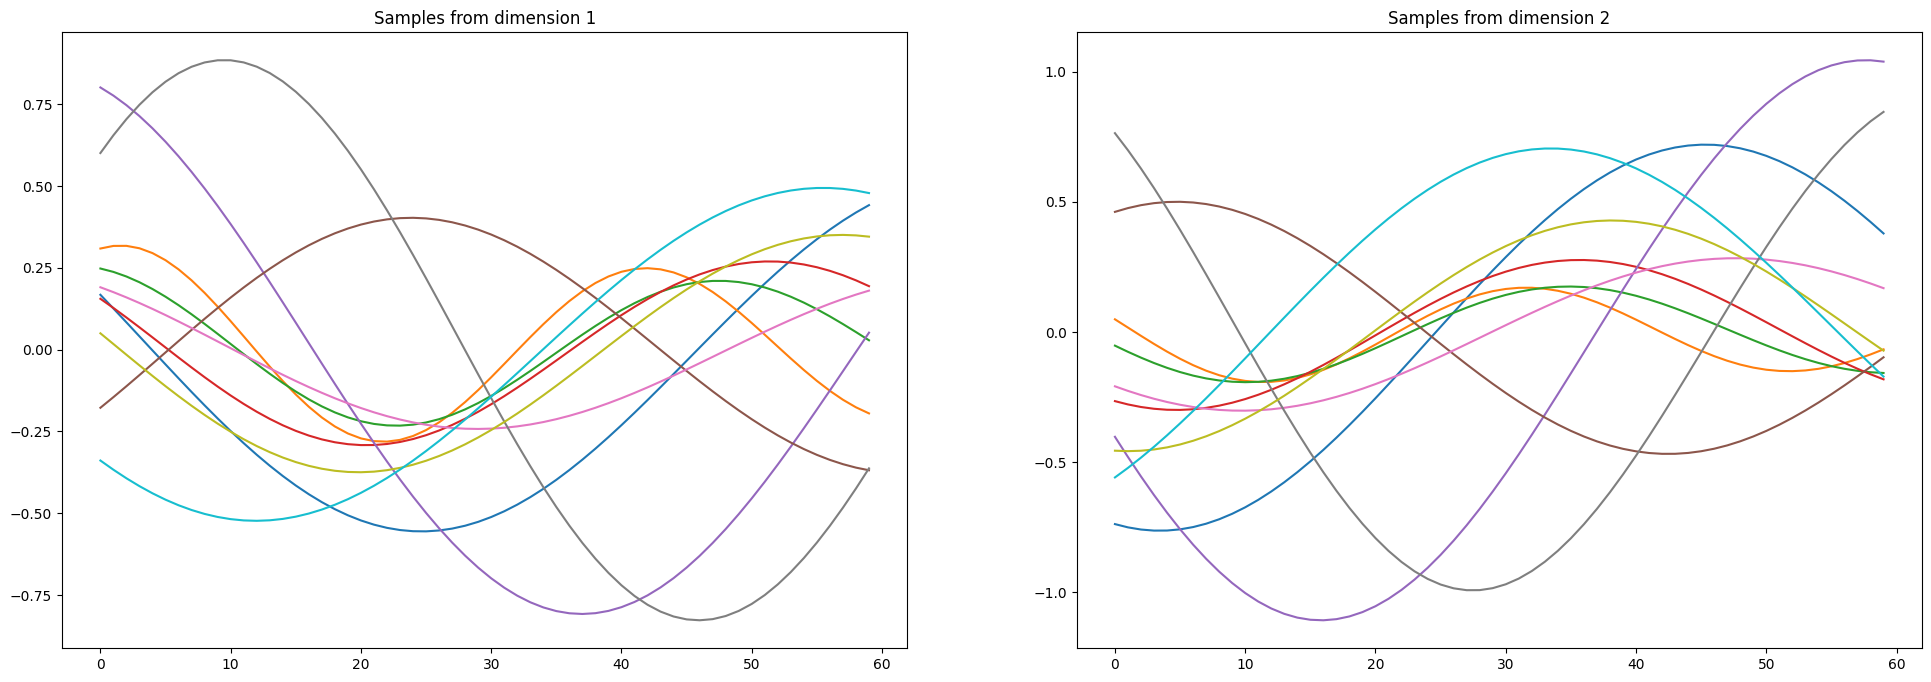

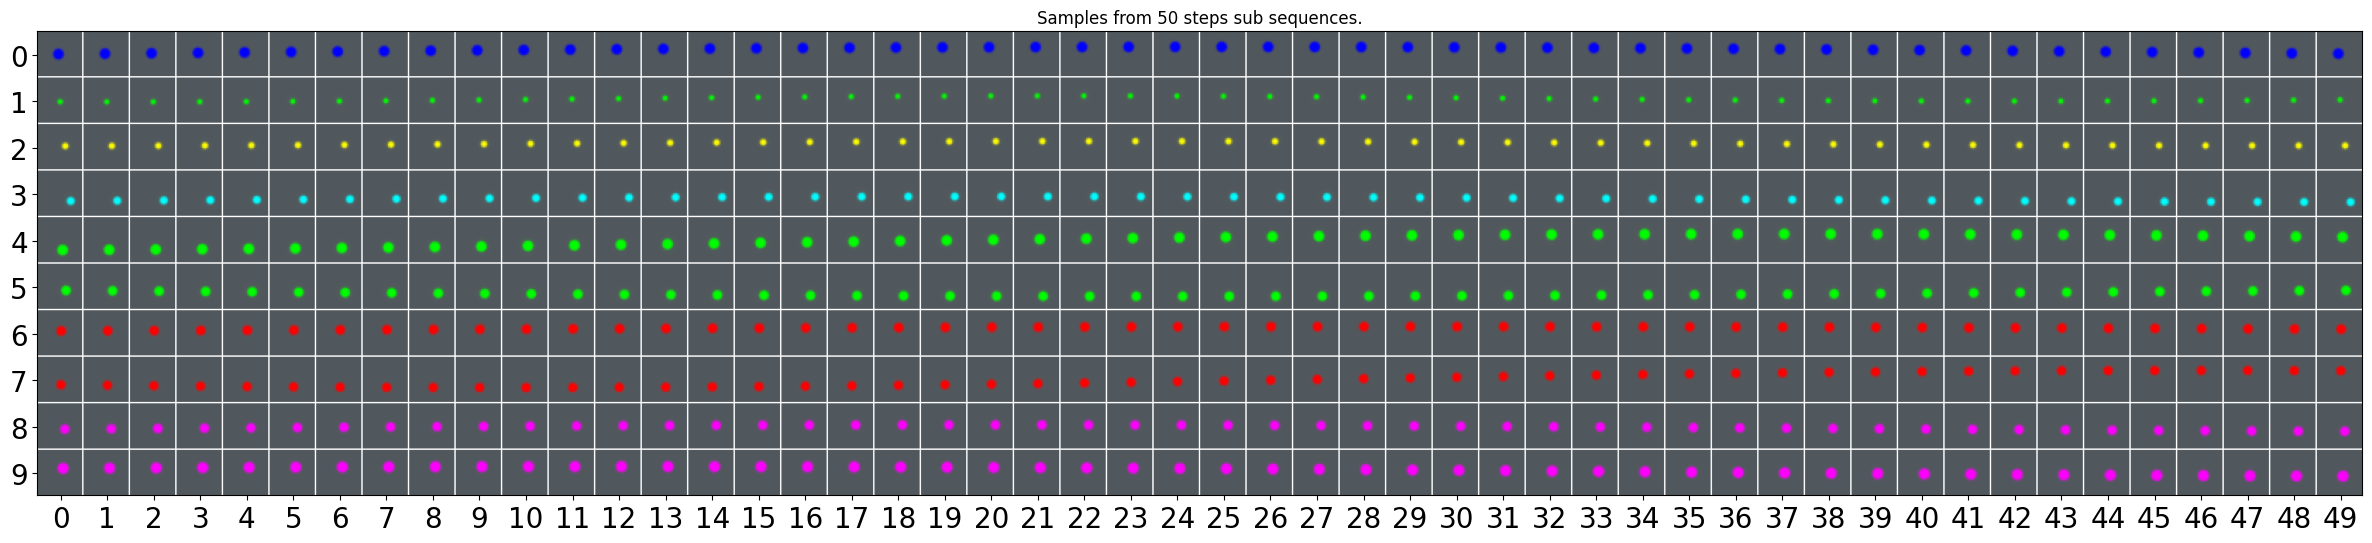

/tmp/ipykernel_485217/2729611134.py:81: UserWarning: You passed in an explicit save_count=60 which is being ignored in favor of len(frames)=300.
  anim = plt_animation.FuncAnimation(


In [5]:
# Visualize the dataset
visualize_dataset(str(DATASETS_FOLDER / dataset_name))